## Import the Needed Libraries

In [1]:
fileName='VA_network_dbd_connections'

In [2]:
try:
    import pyNN.spiNNaker as sim
except ModuleNotFoundError:
    import pyNN.brian2 as sim

from pyNN import space 
from pyNN.random import NumpyRNG, RandomDistribution
from pyNN.utility.plotting import Figure, Panel
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import scipy
import socket
import pickle
import time
import datetime
import json
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

savePath = f'../outputs/' # remember to create the folder if not already present (mkdir ./notebooks/outputs)
dt_string = datetime.datetime.today().isoformat() # ISO8601 ! :-)
tag = dt_string 
saveName = f'{savePath}{fileName}-{tag}'
print(saveName)
PARS={}

../outputs/VA_network_dbd_connections-2024-02-07T22:42:07.592565


## Single Cell Type & Parameters

In [3]:
# cell type
celltype = sim.IF_cond_exp
#  Leaky integrate and fire model with fixed threshold and exponentially-decaying post-synaptic conductance.
#  http://neuralensemble.org/docs/PyNN/_modules/pyNN/standardmodels/cells.html#IF_cond_exp
    
# Cell parameters
area = 20000.     # (µm²)
tau_m = 20.       # (ms)
cm = 1.           # (µF/cm²)
g_leak = 5e-5     # (S/cm²)


E_leak = -60.  # (mV)
v_thresh = -50.   # (mV)
v_reset = -60.    # (mV)
t_refrac = 5.     # (ms) (time during wich v is clamped at v_reset)
v_mean = -60.     # (mV) mean membrane potential, for calculating CUBA weights
tau_exc = 5.      # (ms)
tau_inh = 10.     # (ms)
Erev_exc = 0.     # (mV)
Erev_inh = -80.   # (mV)

# max conductances
Gexc = 4.     # (nS) 
Ginh = 51.    # (nS) 
w_exc = Gexc * 1e-3              # We convert conductances to uS
w_inh = Ginh * 1e-3

# === Calculate derived parameters ===
area = area * 1e-8                     # convert to cm²
cm = cm * area * 1000                  # convert to nF
Rm = 1e-6 / (g_leak * area)            # membrane resistance in MΩ
assert tau_m == cm * Rm                # just to check

cell_params = {'tau_m': tau_m,
               'tau_syn_E': tau_exc,
               'tau_syn_I': tau_inh,
               'v_rest': E_leak,
               'v_reset': v_reset,
               'v_thresh': v_thresh,
               'cm': cm,
               'tau_refrac': t_refrac,
               'i_offset': 0,
               'e_rev_E': Erev_exc,
               'e_rev_I': Erev_inh
               }

print(cell_params)

{'tau_m': 20.0, 'tau_syn_E': 5.0, 'tau_syn_I': 10.0, 'v_rest': -60.0, 'v_reset': -60.0, 'v_thresh': -50.0, 'cm': 0.2, 'tau_refrac': 5.0, 'i_offset': 0, 'e_rev_E': 0.0, 'e_rev_I': -80.0}


## Simulations to Try the Different Possible Combinations

In [4]:
rngseed = 98766987
rng = NumpyRNG(seed=rngseed, parallel_safe=True)

# here we define the possible combinations for synapse and connection types
connection_types = {'all_to_all': sim.AllToAllConnector(allow_self_connections=True), # this param means exc can connect to exc etc. 
                    'low_prob': sim.FixedProbabilityConnector(0.02, rng=rng),
                    'high_prob': sim.FixedProbabilityConnector(0.5, rng=rng)}
synapse_types = {'distance_based_delay': 
                 [sim.StaticSynapse(weight=w_exc, delay="0.5 + 0.01*d"), 
                 sim.StaticSynapse(weight=w_inh, delay="0.5 + 0.01*d")],
                 'fixed_delay': 
                 [sim.StaticSynapse(weight=w_exc, delay=2), 
                 sim.StaticSynapse(weight=w_inh, delay=2)]}
import itertools # to use product make all the combinations

In [5]:
# this is the class to do all the simulations
class simulations:
    def __init__(self, sim):
        self.sim = sim
        self.celltype = celltype
        self.cell_params = cell_params
        self.rng = rng
        self.pops = {}
        self.res = []  # list to contain all the results for the combinations

    def create_populations(self):
        n = 1500          # number of cells
        r_ei = 4.0        # number of excitatory cells:number of inhibitory cells
        n_exc = int(round((n * r_ei / (1 + r_ei))))  # number of excitatory cells
        n_inh = n - n_exc                            # number of inhibitory cells
        print("{} {}".format(n_exc, n_inh))

        # weights of the excitatory and inhibitory postsynaptic connections
        w_exc = Gexc * 1e-3              # We convert conductances to uS
        w_inh = Ginh * 1e-3

        # we define the spherical space in which all the cells will stay in
        # this is needed to add constraints or behaviours that depend on distance (e.g., distance-based delay)
        sphere = space.RandomStructure(
                                                    boundary=space.Sphere(radius=1520),  # here we put radius = n_exc + n_inh + n_thalam
                                                    origin=(0.0, 0.0, 0.0), 
                                                    rng=rng)

        self.pops = {
            'exc': sim.Population(
                                        n_exc, 
                                        celltype(**cell_params), 
                                        label="Excitatory_Cells",
                                        structure = sphere),

            'inh': sim.Population(
                                        n_inh, 
                                        celltype(**cell_params), 
                                        label="Inhibitory_Cells",
                                        structure = sphere)
        }

        self.pops['exc'].record(["spikes", 'v', 'gsyn_exc', 'gsyn_inh'])
        self.pops['inh'].record(["spikes", 'v', 'gsyn_exc', 'gsyn_inh'])


        uniformDistr = RandomDistribution('uniform', [v_reset, v_thresh], rng=rng)
        self.pops['exc'].initialize(v=uniformDistr)
        self.pops['inh'].initialize(v=uniformDistr)

        self.pops.keys()
        
        n_thalamic_cells = 20 
        stim_dur = 50.    # (ms) duration of random stimulation
        rate = 100.       # (Hz) frequency of the random stimulation

        self.pops['thalamus'] = sim.Population(
        n_thalamic_cells, 
        sim.SpikeSourcePoisson(rate=rate, duration=stim_dur),
        structure = sphere,
        label="expoisson")
        self.pops['thalamus'].record("spikes")

        
    # to create all the pop connections with the combinations of conn_type and syn_type for the loop below
    def create_connections(self, conn_type, syn_type):
        pops = self.pops
        rconn = 0.01
        ext_conn = sim.FixedProbabilityConnector(rconn)
        
        
        connections = {

            'e2e': sim.Projection(
                pops['exc'],
                pops['exc'],
                conn_type,    
                receptor_type='excitatory',
                synapse_type=syn_type[0]),    # 1st element is for exc synapses

            'e2i': sim.Projection(
                pops['exc'],
                pops['inh'],
                conn_type,
                receptor_type='excitatory',
                synapse_type=syn_type[0]),

            'i2e': sim.Projection(
                pops['inh'],
                pops['exc'],
                conn_type,    
                receptor_type='inhibitory',
                synapse_type=syn_type[1]),    # 2nd element is for inh synapses

            'i2i': sim.Projection(
                pops['inh'],
                pops['inh'],
                conn_type,
                receptor_type='inhibitory',
                synapse_type=syn_type[1])

                }

        connections['ext2e'] = sim.Projection(
            pops['thalamus'],
            pops['exc'],
            ext_conn,
            receptor_type='excitatory',
            synapse_type=sim.StaticSynapse(weight=0.1))

        connections['ext2i'] = sim.Projection(
            pops['thalamus'],
            pops['inh'],
            ext_conn,
            receptor_type='excitatory',
            synapse_type=sim.StaticSynapse(weight=0.1))

        connections.keys(), pops.keys()
        

    def run_simulation(self, simtime):
        
        # simulation run
        tic = time.time()
        self.sim.run(simtime) # simtime is in ms
        toc = time.time() - tic
        print("Combination simulation finished in", int(toc), "seconds")
    
    # loop over all the possible combinations, to run simulation, save results and add them to the results tuple
    def experiments(self):
        i = 0
        for connection_type, synapse_type in itertools.product(connection_types, synapse_types):
                i +=1
                combname = f'{connection_type}-{synapse_type}'
                filesave = f'{saveName}-{connection_type}-{synapse_type}.pkl'
                connec = connection_types[connection_type]
                synap = synapse_types[synapse_type]
                
                self.setup()
                self.create_populations()
                self.create_connections(connec, synap)
                print("Starting simulation", i , "of", len(connection_types)*len(synapse_types))
                self.run_simulation(1000)
                self.save_results(combname, filesave)
                print("Combination Data Saved.")
                self.end()
                
        
    # Function needed for the retrieval of saved data
    def recover_results(self, outputs):
        results = {}
        for key in outputs.keys(): # to extract the name of the layer, e.g., Exc, Inh, Thalamus, etc
            # to get voltage and conductances
            for analogsignal in outputs[key].segments[0].analogsignals:
                print(analogsignal.name)
                results[key, analogsignal.name] = analogsignal

            # to get spikes
            VAR=outputs[key].segments[0].spiketrains
            results[key, 'spikes']=[]
            for k in range(len(VAR)):
                results[key, 'spikes'].append(np.array(list(VAR[k])).T,)
        return results 
                
    def save_results(self, combin_name, file_name):

        
        stateVars = {}
        for pop in self.pops.keys():
            for recording in ['v', 'gsyn_inh', 'gsyn_exc', 'spikes']:
                self.pops[pop].write_data(file_name)
                stateVars[f'{combin_name}-{pop}']=self.pops[pop].get_data()
        
        results = self.recover_results(stateVars)
        self.res.append(results)
        fig, ax = plt.subplots(2,1, sharex=True, figsize=(9,5))
        p0=ax[0].eventplot(results[f'{combin_name}-exc', 'spikes'], color='green')
        p1=ax[1].eventplot(results[f'{combin_name}-inh', 'spikes'], color='red')
        [ax[i].set_xlabel('Time (ms)', fontsize=14) for i in [0,1]]
        [ax[i].set_ylabel(feat, fontsize=14) for i, feat in enumerate(['Excitatory cells', 'Inhibitory cells'])]
        
    def setup(self):
        dt = 1          # (ms) simulation timestep
        self.sim.setup(
            timestep=dt, 
            min_delay=1, 
            max_delay=100) # [ms] 
    
    def end(self):
        self.sim.end() # needed to change the connection types

## Run the Simulation

2024-02-07 22:42:07 INFO: Read cfg files: /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/interface/spinnaker.cfg, /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/spynnaker.cfg, /home/bbpnrsoa/.spynnaker.cfg
2024-02-07 22:42:07 INFO: Will search these locations for binaries: /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/common_model_binaries : /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/model_binaries
2024-02-07 22:42:07 INFO: Setting time scale factor to 1.
2024-02-07 22:42:07 INFO: Setting machine time step to 1000 micro-seconds.
2024-02-07 22:42:07 INFO: Starting execution process
2024-02-07 22:42:07 INFO: Simulating for 1000 1.0ms timesteps using a hardware timestep of 1000us


['/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/bbpnrsoa/.spynnaker.cfg']
1200 300
Starting simulation 1 of 6


Adding Splitter selectors where appropriate
|0%                          50%                         100%|
2024-02-07 22:42:07 INFO: Time 0:00:00.013967 taken by SpynnakerSplitterSelector
Adding delay extensions as required
|0%                          50%                         100%|
2024-02-07 22:42:08 INFO: Time 0:00:00.153390 taken by DelaySupportAdder
2024-02-07 22:42:13 INFO: Time 0:00:05.885045 taken by SpallocMaxMachineGenerator
Preallocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2024-02-07 22:42:30 INFO: Time 0:00:16.746754 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2024-02-07 22:42:46 INFO: Time 0:00:16.291905 taken by SpYNNakerSplitterPartitioner
Created spalloc job 389431
2024-02-07 22:42:46 INFO: Created spalloc job 38

Combination simulation finished in 306 seconds


Getting v for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_exc for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_inh for Excitatory_Cells
|0%                          50%                         100%|
Getting spikes for Excitatory_Cells
|0%                          50%                         100%|
Getting v for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_exc for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_inh for Excitatory_Cells
|0%                          50%                         100%|
Getting spikes for Excitatory_Cells
|0%                          50%                         100%|
Getting v for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_exc for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_in

v
gsyn_exc
gsyn_inh
v
gsyn_exc
gsyn_inh


2024-02-07 22:47:26 WARNING: The delays in the connector AllToAllConnector from Excitatory_Cells to Excitatory_Cells was clipped to 1.0 a total of 44 times.  This can be avoided by reducing the timestep or increasing the minimum delay to one timestep
2024-02-07 22:47:26 WARNING: The delays in the connector AllToAllConnector from Excitatory_Cells to Inhibitory_Cells was clipped to 1.0 a total of 44 times.  This can be avoided by reducing the timestep or increasing the minimum delay to one timestep
2024-02-07 22:47:26 WARNING: The delays in the connector AllToAllConnector from Inhibitory_Cells to Excitatory_Cells was clipped to 1.0 a total of 44 times.  This can be avoided by reducing the timestep or increasing the minimum delay to one timestep
2024-02-07 22:47:26 WARNING: The delays in the connector AllToAllConnector from Inhibitory_Cells to Inhibitory_Cells was clipped to 1.0 a total of 44 times.  This can be avoided by reducing the timestep or increasing the minimum delay to one times

Combination Data Saved.
['/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/bbpnrsoa/.spynnaker.cfg']
1200 300
Starting simulation 2 of 6


Adding delay extensions as required
|0%                          50%                         100%|
2024-02-07 22:47:26 INFO: Time 0:00:00.029592 taken by DelaySupportAdder
2024-02-07 22:47:31 INFO: Time 0:00:04.675687 taken by SpallocMaxMachineGenerator
Preallocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2024-02-07 22:47:50 INFO: Time 0:00:19.183051 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2024-02-07 22:48:02 INFO: Time 0:00:11.314649 taken by SpYNNakerSplitterPartitioner
Created spalloc job 389432
2024-02-07 22:48:02 INFO: Created spalloc job 389432
Waiting for board power commands to complete.
2024-02-07 22:48:02 INFO: Waiting for board power commands to complete.
2024-02-07 22:48:10 INFO: Time 0:00:08.701504 taken by SpallocAll

Combination simulation finished in 103 seconds


Getting v for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_exc for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_inh for Excitatory_Cells
|0%                          50%                         100%|
Getting spikes for Excitatory_Cells
|0%                          50%                         100%|
Getting v for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_exc for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_inh for Excitatory_Cells
|0%                          50%                         100%|
Getting spikes for Excitatory_Cells
|0%                          50%                         100%|
Getting v for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_exc for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_in

v
gsyn_exc
gsyn_inh
v
gsyn_exc
gsyn_inh


2024-02-07 22:49:23 WARNING: The delays in the connector AllToAllConnector from Excitatory_Cells to Excitatory_Cells was clipped to 1.0 a total of 44 times.  This can be avoided by reducing the timestep or increasing the minimum delay to one timestep
2024-02-07 22:49:23 WARNING: The delays in the connector AllToAllConnector from Excitatory_Cells to Inhibitory_Cells was clipped to 1.0 a total of 44 times.  This can be avoided by reducing the timestep or increasing the minimum delay to one timestep
2024-02-07 22:49:23 WARNING: The delays in the connector AllToAllConnector from Inhibitory_Cells to Excitatory_Cells was clipped to 1.0 a total of 44 times.  This can be avoided by reducing the timestep or increasing the minimum delay to one timestep
2024-02-07 22:49:23 WARNING: The delays in the connector AllToAllConnector from Inhibitory_Cells to Inhibitory_Cells was clipped to 1.0 a total of 44 times.  This can be avoided by reducing the timestep or increasing the minimum delay to one times

Combination Data Saved.
['/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/bbpnrsoa/.spynnaker.cfg']
1200 300
Starting simulation 3 of 6


2024-02-07 22:49:23 INFO: Time 0:00:00.158443 taken by DelaySupportAdder
2024-02-07 22:49:27 INFO: Time 0:00:04.058845 taken by SpallocMaxMachineGenerator
Preallocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2024-02-07 22:49:46 INFO: Time 0:00:19.118290 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2024-02-07 22:49:59 INFO: Time 0:00:13.138451 taken by SpYNNakerSplitterPartitioner
Created spalloc job 389433
2024-02-07 22:49:59 INFO: Created spalloc job 389433
Job has been queued by the spalloc server.
2024-02-07 22:49:59 INFO: Job has been queued by the spalloc server.
Waiting for board power commands to complete.
2024-02-07 22:50:03 INFO: Waiting for board power commands to complete.
2024-02-07 22:50:12 INFO: Time 0:00:12.800196 taken 

Combination simulation finished in 146 seconds


Getting v for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_exc for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_inh for Excitatory_Cells
|0%                          50%                         100%|
Getting spikes for Excitatory_Cells
|0%                          50%                         100%|
Getting v for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_exc for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_inh for Excitatory_Cells
|0%                          50%                         100%|
Getting spikes for Excitatory_Cells
|0%                          50%                         100%|
Getting v for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_exc for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_in

v
gsyn_exc
gsyn_inh
v
gsyn_exc
gsyn_inh


2024-02-07 22:52:00 WARNING: 4336 packets from Excitatory_Cells:0:255 on 4, 4, 3 were dropped from the input buffer, because they arrived too late to be processed in a given time step. Try increasing the time_scale_factor located within the .spynnaker.cfg file or in the pynn.setup() method.
2024-02-07 22:52:00 WARNING: A maximum of 8 background tasks were queued on Excitatory_Cells:0:255 on 4, 4, 3.  Try increasing the time_scale_factor located within the .spynnaker.cfg file or in the pynn.setup() method.
2024-02-07 22:52:00 WARNING: The delay extension DelayExtensionsMachineVertex for Excitatory_Cells with 1200 atoms with slice Slice(lo_atom=256, hi_atom=511, n_atoms=256) on 5, 4, 2 only processed 5476 of 5478 received packets.  This could indicate a fault.
2024-02-07 22:52:00 WARNING: 2 packets from DelayExtensionsMachineVertex for Excitatory_Cells with 1200 atoms with slice Slice(lo_atom=256, hi_atom=511, n_atoms=256) on 5, 4, 2 were dropped from the input buffer, because they arriv

Combination Data Saved.
['/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/bbpnrsoa/.spynnaker.cfg']
1200 300
Starting simulation 4 of 6


2024-02-07 22:52:06 INFO: Time 0:00:05.928300 taken by SpallocMaxMachineGenerator
Preallocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2024-02-07 22:52:26 INFO: Time 0:00:20.008144 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2024-02-07 22:52:33 INFO: Time 0:00:07.230709 taken by SpYNNakerSplitterPartitioner
Created spalloc job 389434
2024-02-07 22:52:33 INFO: Created spalloc job 389434
Job has been queued by the spalloc server.
2024-02-07 22:52:33 INFO: Job has been queued by the spalloc server.
Waiting for board power commands to complete.
2024-02-07 22:52:33 INFO: Waiting for board power commands to complete.
2024-02-07 22:52:42 INFO: Time 0:00:08.878383 taken by SpallocAllocator
2024-02-07 22:52:42 INFO: Creating transceiver for 10

Combination simulation finished in 107 seconds


Getting v for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_exc for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_inh for Excitatory_Cells
|0%                          50%                         100%|
Getting spikes for Excitatory_Cells
|0%                          50%                         100%|
Getting v for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_exc for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_inh for Excitatory_Cells
|0%                          50%                         100%|
Getting spikes for Excitatory_Cells
|0%                          50%                         100%|
Getting v for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_exc for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_in

v
gsyn_exc
gsyn_inh
v
gsyn_exc
gsyn_inh


2024-02-07 22:53:57 WARNING: 44 packets from Excitatory_Cells:0:255 on 4, 4, 2 were dropped from the input buffer, because they arrived too late to be processed in a given time step. Try increasing the time_scale_factor located within the .spynnaker.cfg file or in the pynn.setup() method.
2024-02-07 22:53:57 WARNING: A maximum of 4 background tasks were queued on Excitatory_Cells:0:255 on 4, 4, 2.  Try increasing the time_scale_factor located within the .spynnaker.cfg file or in the pynn.setup() method.
2024-02-07 22:53:57 WARNING: 37 packets from Excitatory_Cells:256:511 on 5, 4, 2 were dropped from the input buffer, because they arrived too late to be processed in a given time step. Try increasing the time_scale_factor located within the .spynnaker.cfg file or in the pynn.setup() method.
2024-02-07 22:53:57 WARNING: A maximum of 3 background tasks were queued on Excitatory_Cells:256:511 on 5, 4, 2.  Try increasing the time_scale_factor located within the .spynnaker.cfg file or in the

Combination Data Saved.
['/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/bbpnrsoa/.spynnaker.cfg']
1200 300
Starting simulation 5 of 6


2024-02-07 22:53:57 INFO: Time 0:00:00.203487 taken by DelaySupportAdder
2024-02-07 22:54:02 INFO: Time 0:00:04.801084 taken by SpallocMaxMachineGenerator
Preallocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2024-02-07 22:54:21 INFO: Time 0:00:18.948171 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2024-02-07 22:54:39 INFO: Time 0:00:17.809428 taken by SpYNNakerSplitterPartitioner
Created spalloc job 389435
2024-02-07 22:54:39 INFO: Created spalloc job 389435
Waiting for board power commands to complete.
2024-02-07 22:54:39 INFO: Waiting for board power commands to complete.
2024-02-07 22:54:48 INFO: Time 0:00:08.707022 taken by SpallocAllocator
2024-02-07 22:54:48 INFO: Creating transceiver for 10.11.222.9
2024-02-07 22:54:48 INFO: Wor

Combination simulation finished in 216 seconds


Getting v for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_exc for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_inh for Excitatory_Cells
|0%                          50%                         100%|
Getting spikes for Excitatory_Cells
|0%                          50%                         100%|
Getting v for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_exc for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_inh for Excitatory_Cells
|0%                          50%                         100%|
Getting spikes for Excitatory_Cells
|0%                          50%                         100%|
Getting v for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_exc for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_in

v
gsyn_exc
gsyn_inh
v
gsyn_exc
gsyn_inh


2024-02-07 22:57:46 WARNING: The delays in the connector FixedProbabilityConnector from Excitatory_Cells to Excitatory_Cells was clipped to 1.0 a total of 20 times.  This can be avoided by reducing the timestep or increasing the minimum delay to one timestep
2024-02-07 22:57:46 WARNING: The delays in the connector FixedProbabilityConnector from Excitatory_Cells to Inhibitory_Cells was clipped to 1.0 a total of 20 times.  This can be avoided by reducing the timestep or increasing the minimum delay to one timestep
2024-02-07 22:57:46 WARNING: The delays in the connector FixedProbabilityConnector from Inhibitory_Cells to Excitatory_Cells was clipped to 1.0 a total of 20 times.  This can be avoided by reducing the timestep or increasing the minimum delay to one timestep
2024-02-07 22:57:46 WARNING: The delays in the connector FixedProbabilityConnector from Inhibitory_Cells to Inhibitory_Cells was clipped to 1.0 a total of 20 times.  This can be avoided by reducing the timestep or increasin

Combination Data Saved.
['/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/bbpnrsoa/.spynnaker.cfg']
1200 300
Starting simulation 6 of 6



2024-02-07 22:57:46 INFO: Time 0:00:00.021967 taken by SpynnakerSplitterSelector
Adding delay extensions as required
|0%                          50%                         100%|
2024-02-07 22:57:46 INFO: Time 0:00:00.024531 taken by DelaySupportAdder
2024-02-07 22:57:52 INFO: Time 0:00:06.531995 taken by SpallocMaxMachineGenerator
Preallocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2024-02-07 22:58:08 INFO: Time 0:00:15.927167 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2024-02-07 22:58:20 INFO: Time 0:00:11.710911 taken by SpYNNakerSplitterPartitioner
Created spalloc job 389436
2024-02-07 22:58:20 INFO: Created spalloc job 389436
Waiting for board power commands to complete.
2024-02-07 22:58:20 INFO: Waiting for board power comma

Combination simulation finished in 111 seconds


Getting v for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_exc for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_inh for Excitatory_Cells
|0%                          50%                         100%|
Getting spikes for Excitatory_Cells
|0%                          50%                         100%|
Getting v for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_exc for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_inh for Excitatory_Cells
|0%                          50%                         100%|
Getting spikes for Excitatory_Cells
|0%                          50%                         100%|
Getting v for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_exc for Excitatory_Cells
|0%                          50%                         100%|
Getting gsyn_in

v
gsyn_exc
gsyn_inh
v
gsyn_exc
gsyn_inh


2024-02-07 22:59:50 WARNING: The delays in the connector FixedProbabilityConnector from Excitatory_Cells to Excitatory_Cells was clipped to 1.0 a total of 20 times.  This can be avoided by reducing the timestep or increasing the minimum delay to one timestep
2024-02-07 22:59:50 WARNING: The delays in the connector FixedProbabilityConnector from Excitatory_Cells to Inhibitory_Cells was clipped to 1.0 a total of 20 times.  This can be avoided by reducing the timestep or increasing the minimum delay to one timestep
2024-02-07 22:59:50 WARNING: The delays in the connector FixedProbabilityConnector from Inhibitory_Cells to Excitatory_Cells was clipped to 1.0 a total of 20 times.  This can be avoided by reducing the timestep or increasing the minimum delay to one timestep
2024-02-07 22:59:50 WARNING: The delays in the connector FixedProbabilityConnector from Inhibitory_Cells to Inhibitory_Cells was clipped to 1.0 a total of 20 times.  This can be avoided by reducing the timestep or increasin

Combination Data Saved.
All simulations finished in 1062 seconds


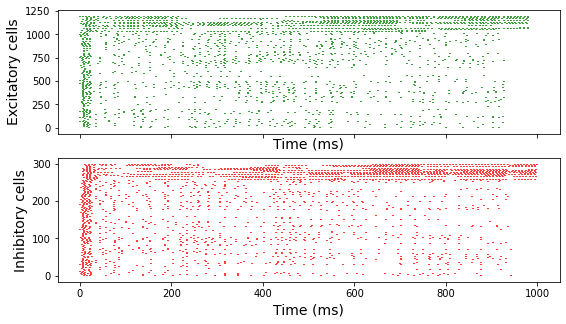

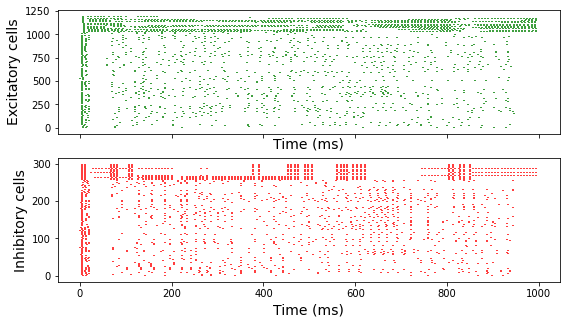

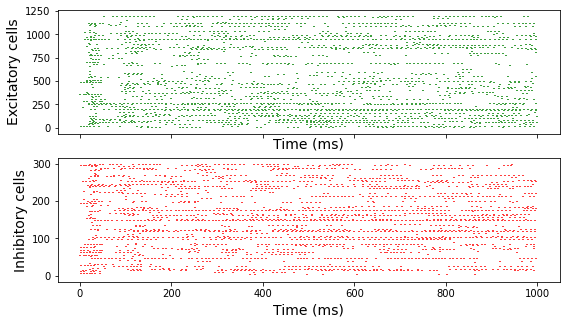

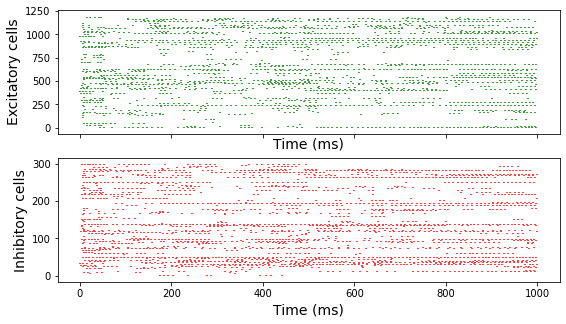

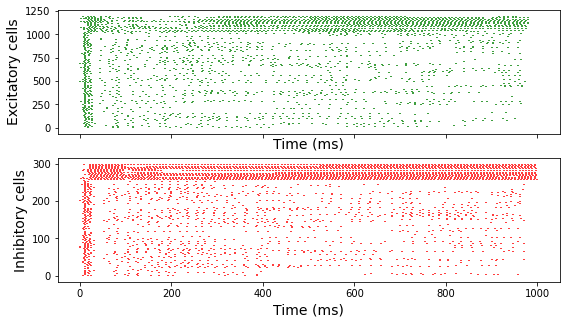

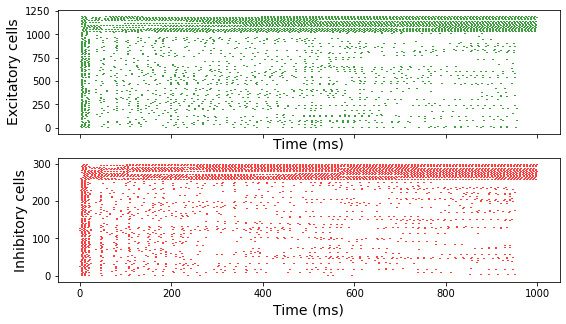

In [6]:
tic = time.time()
exp = simulations(sim)
exp.experiments()
toc = time.time() - tic
print("All simulations finished in", int(toc), "seconds")

## Postprocessing

### Excitatory Spikes

In [30]:
spike_count_lists_exc = np.zeros((6, 999))

comb_names_exc = []
for conn, syn in itertools.product(connection_types, synapse_types):
    comb_names_exc.append(f'{conn}-{syn}-exc')

spike_count_exc = np.zeros(999)

for n in range(len(exp.res)):
    for x in range(0,999):
        tot=0
        for ele in exp.res[n][comb_names_exc[n], 'spikes']:
            if float(x) in ele:
                tot += 1
                
        spike_count_exc[x] = tot
            
    spike_count_lists_exc[n] = spike_count_exc

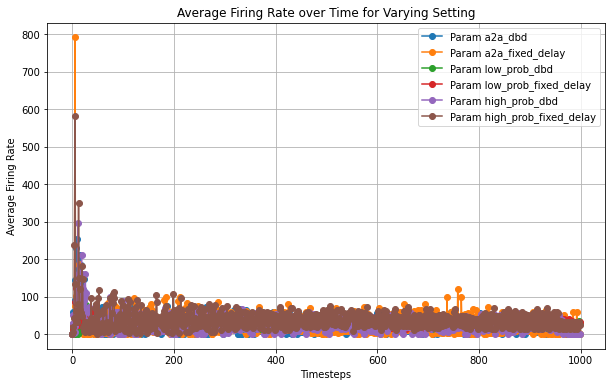

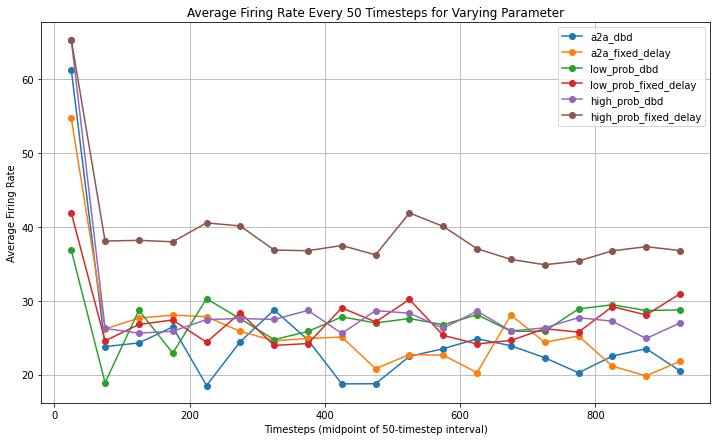

''

In [31]:
timesteps = list(range(999)) 

firing_rates_simulation = {
    'a2a_dbd': spike_count_lists_exc[0],
    'a2a_fixed_delay': spike_count_lists_exc[1],
    'low_prob_dbd': spike_count_lists_exc[2],
    'low_prob_fixed_delay': spike_count_lists_exc[3],
    'high_prob_dbd': spike_count_lists_exc[4],
    'high_prob_fixed_delay': spike_count_lists_exc[5]
}

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot each simulation's average firing rate over time
for param_value, rates in firing_rates_simulation.items():
    plt.plot(timesteps, rates, marker='o', linestyle='-', label=f'Param {param_value}')

# Adding labels, title, and legend
plt.xlabel('Timesteps')
plt.ylabel('Average Firing Rate')
plt.title('Average Firing Rate over Time for Varying Setting')
plt.legend()

# Optional: Add grid for easier reading
plt.grid(True)

# Show the plot
plt.show()
plt.savefig('exc_stim_dur.png', dpi=1500)  # Specify the path and filename, and optionally the DPI

# After saving, you might want to close the plot if you're done with it
plt.close()
import numpy as np

# Function to calculate averages every 50 timesteps
def calculate_averages_every_50(rates):
    # Convert the list to a numpy array for easier slicing
    rates_array = np.array(rates)
    # Calculate the number of complete chunks of 50
    num_chunks = len(rates) // 50
    # Calculate averages for each chunk
    averages = [np.mean(rates_array[i*50:(i+1)*50]) for i in range(num_chunks)]
    return averages

# Apply the function to each simulation's firing rates
averaged_firing_rates_simulation = {param: calculate_averages_every_50(rates) for param, rates in firing_rates_simulation.items()}

# Adjusted timesteps for plotting (using the midpoint of each 50-timestep interval as the x-value)
adjusted_timesteps = [25 + i*50 for i in range(len(averaged_firing_rates_simulation['a2a_dbd']))]
# Create the plot with adjusted figure size
plt.figure(figsize=(12, 7))

# Plot each simulation's averaged firing rate over time
for param_value, averages in averaged_firing_rates_simulation.items():
    plt.plot(adjusted_timesteps, averages, marker='o', linestyle='-', label=f'{param_value}')

# Adding labels, title, and legend
plt.xlabel('Timesteps (midpoint of 50-timestep interval)')
plt.ylabel('Average Firing Rate')
plt.title('Average Firing Rate Every 50 Timesteps for Varying Parameter')
plt.legend()

# Add grid for easier reading
plt.grid(True)

# Show the plot
plt.show()

# Save the plot
plt.savefig('averaged_exc_stim_dur_50.png', dpi=500)  # Adjust filename and DPI as needed

# Close the plot
plt.close()
''''''

### Inhibitory Spikes

In [32]:
spike_count_lists_inh = np.zeros((6, 999))

comb_names_inh = []
for conn, syn in itertools.product(connection_types, synapse_types):
    comb_names_inh.append(f'{conn}-{syn}-inh')

spike_count_inh = np.zeros(999)

for n in range(len(exp.res)):
    for x in range(0,999):
        tot=0
        for ele in exp.res[n][comb_names_inh[n], 'spikes']:
            if float(x) in ele:
                tot += 1
                
        spike_count_inh[x] = tot
            
    spike_count_lists_inh[n] = spike_count_inh

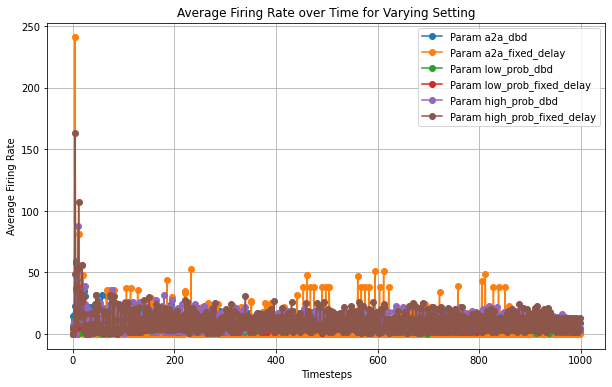

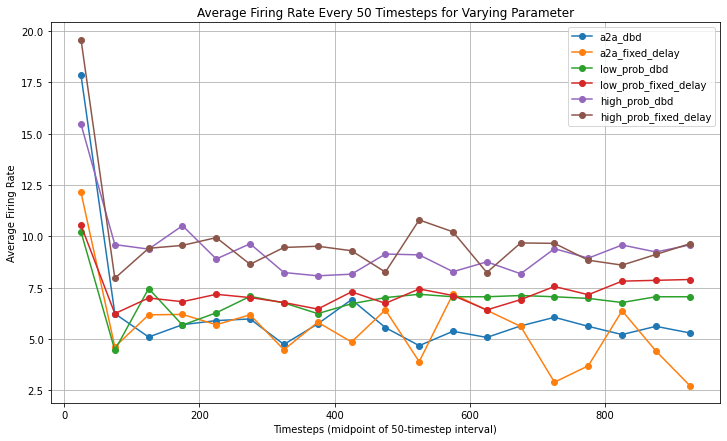

''

In [33]:
timesteps = list(range(999)) 

firing_rates_simulation = {
    'a2a_dbd': spike_count_lists_inh[0],
    'a2a_fixed_delay': spike_count_lists_inh[1],
    'low_prob_dbd': spike_count_lists_inh[2],
    'low_prob_fixed_delay': spike_count_lists_inh[3],
    'high_prob_dbd': spike_count_lists_inh[4],
    'high_prob_fixed_delay': spike_count_lists_inh[5]
}

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot each simulation's average firing rate over time
for param_value, rates in firing_rates_simulation.items():
    plt.plot(timesteps, rates, marker='o', linestyle='-', label=f'Param {param_value}')

# Adding labels, title, and legend
plt.xlabel('Timesteps')
plt.ylabel('Average Firing Rate')
plt.title('Average Firing Rate over Time for Varying Setting')
plt.legend()

# Optional: Add grid for easier reading
plt.grid(True)

# Show the plot
plt.show()
plt.savefig('inh_stim_dur.png', dpi=1500)  # Specify the path and filename, and optionally the DPI

# After saving, you might want to close the plot if you're done with it
plt.close()
import numpy as np

# Function to calculate averages every 50 timesteps
def calculate_averages_every_50(rates):
    # Convert the list to a numpy array for easier slicing
    rates_array = np.array(rates)
    # Calculate the number of complete chunks of 50
    num_chunks = len(rates) // 50
    # Calculate averages for each chunk
    averages = [np.mean(rates_array[i*50:(i+1)*50]) for i in range(num_chunks)]
    return averages

# Apply the function to each simulation's firing rates
averaged_firing_rates_simulation = {param: calculate_averages_every_50(rates) for param, rates in firing_rates_simulation.items()}

# Adjusted timesteps for plotting (using the midpoint of each 50-timestep interval as the x-value)
adjusted_timesteps = [25 + i*50 for i in range(len(averaged_firing_rates_simulation['a2a_dbd']))]
# Create the plot with adjusted figure size
plt.figure(figsize=(12, 7))

# Plot each simulation's averaged firing rate over time
for param_value, averages in averaged_firing_rates_simulation.items():
    plt.plot(adjusted_timesteps, averages, marker='o', linestyle='-', label=f'{param_value}')

# Adding labels, title, and legend
plt.xlabel('Timesteps (midpoint of 50-timestep interval)')
plt.ylabel('Average Firing Rate')
plt.title('Average Firing Rate Every 50 Timesteps for Varying Parameter')
plt.legend()

# Add grid for easier reading
plt.grid(True)

# Show the plot
plt.show()

# Save the plot
plt.savefig('averaged_inh_stim_dur_50.png', dpi=500)  # Adjust filename and DPI as needed

# Close the plot
plt.close()
''''''

### Excitatory-Inhibitory Balance

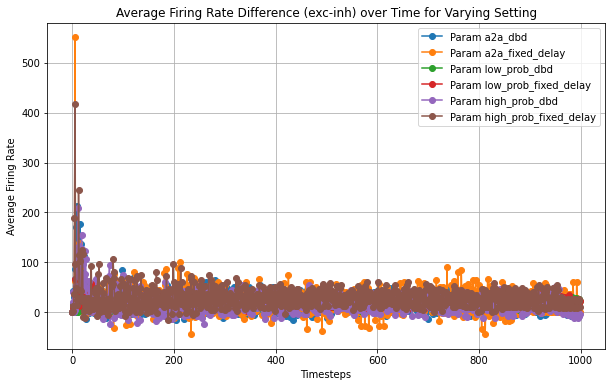

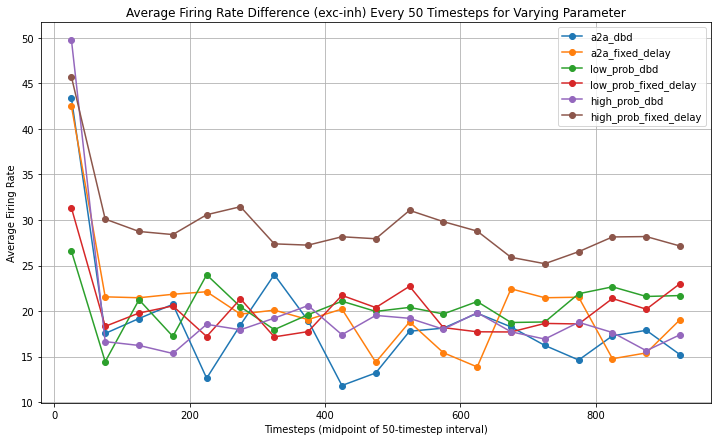

''

In [34]:
timesteps = list(range(999)) 

firing_rates_simulation = {
    'a2a_dbd': spike_count_lists_exc[0] - spike_count_lists_inh[0],
    'a2a_fixed_delay': spike_count_lists_exc[1] - spike_count_lists_inh[1],
    'low_prob_dbd': spike_count_lists_exc[2] - spike_count_lists_inh[2],
    'low_prob_fixed_delay': spike_count_lists_exc[3] - spike_count_lists_inh[3],
    'high_prob_dbd': spike_count_lists_exc[4] - spike_count_lists_inh[4],
    'high_prob_fixed_delay': spike_count_lists_exc[5] - spike_count_lists_inh[5]
}

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot each simulation's average firing rate over time
for param_value, rates in firing_rates_simulation.items():
    plt.plot(timesteps, rates, marker='o', linestyle='-', label=f'Param {param_value}')

# Adding labels, title, and legend
plt.xlabel('Timesteps')
plt.ylabel('Average Firing Rate')
plt.title('Average Firing Rate Difference (exc-inh) over Time for Varying Setting')
plt.legend()

# Optional: Add grid for easier reading
plt.grid(True)

# Show the plot
plt.show()
plt.savefig('diff_stim_dur.png', dpi=1500)  # Specify the path and filename, and optionally the DPI

# After saving, you might want to close the plot if you're done with it
plt.close()
import numpy as np

# Function to calculate averages every 50 timesteps
def calculate_averages_every_50(rates):
    # Convert the list to a numpy array for easier slicing
    rates_array = np.array(rates)
    # Calculate the number of complete chunks of 50
    num_chunks = len(rates) // 50
    # Calculate averages for each chunk
    averages = [np.mean(rates_array[i*50:(i+1)*50]) for i in range(num_chunks)]
    return averages

# Apply the function to each simulation's firing rates
averaged_firing_rates_simulation = {param: calculate_averages_every_50(rates) for param, rates in firing_rates_simulation.items()}

# Adjusted timesteps for plotting (using the midpoint of each 50-timestep interval as the x-value)
adjusted_timesteps = [25 + i*50 for i in range(len(averaged_firing_rates_simulation['a2a_dbd']))]
# Create the plot with adjusted figure size
plt.figure(figsize=(12, 7))

# Plot each simulation's averaged firing rate over time
for param_value, averages in averaged_firing_rates_simulation.items():
    plt.plot(adjusted_timesteps, averages, marker='o', linestyle='-', label=f'{param_value}')

# Adding labels, title, and legend
plt.xlabel('Timesteps (midpoint of 50-timestep interval)')
plt.ylabel('Average Firing Rate')
plt.title('Average Firing Rate Difference (exc-inh) Every 50 Timesteps for Varying Parameter')
plt.legend()

# Add grid for easier reading
plt.grid(True)

# Show the plot
plt.show()

# Save the plot
plt.savefig('averaged_diff_stim_dur_50.png', dpi=500)  # Adjust filename and DPI as needed

# Close the plot
plt.close()
''''''